In [39]:
from scipy import signal
import NNControlled1D.forwardconduction as fc
import NNControlled1D.PIDivmech as PID

import sys, getopt
import math
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt 
import matplotlib.animation as animation
import yaml
from tensorflow import keras
from tensorflow.keras import layers

In [40]:
def externalforce( i, wave='def'):
    offset, mag, freq = -20, 5, math.pi / 20
    if wave == 'def':
        offset, mag, t = 0, -20, i/500
        sig = np.sin(np.pi/2 + 2 * np.pi * t)
        Too = 0.5*(1 - signal.square(2 * np.pi * 30 * t, duty=(sig + 1)/2))
    elif wave == 'constant':
        Too = 0
    elif wave == 'cos':
        Too = 0.5*(1 - math.cos(i*freq))
    elif wave == 'square':
        Too = 0.5*(1 - signal.square( i*freq ))
    elif wave == 'triangle':
        Too = signal.sawtooth( i*freq, 0.5 )
    else:
        raise Exception("bad waveform")
    return Bi * (offset + mag * Too)


Bi, Fo = 1.6, .3
model = fc.X23_gToo_I( Bi, Fo, M=100 )
pid = PID.PID( 3, 3, 0, setpoint=0.0 )
Q = pid.update( 0.0 )
ts, y_Qs, y_Ts, y_Es, y_Hs, stops = [], [], [], [], [], []

data_points = 500
wave_forms = ['def','triangle','constant','cos']
for wave in wave_forms:
    for i in range(data_points):
        H = externalforce(i, wave)
        v = model.getNextTemp(Q, H)
        y_Qs.append( Q ); y_Ts.append( v[0] ); y_Es.append( v[1] ); y_Hs.append( H/Bi ); Q = pid.update( v[0] )

# Kp = 3
# Ki = 3
# Kd = 0


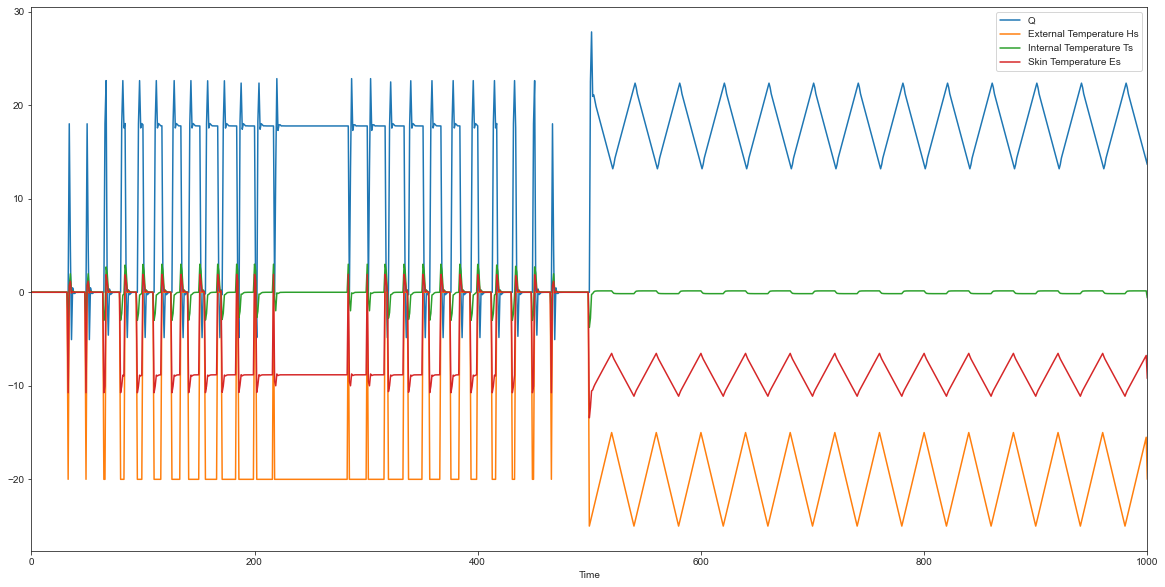

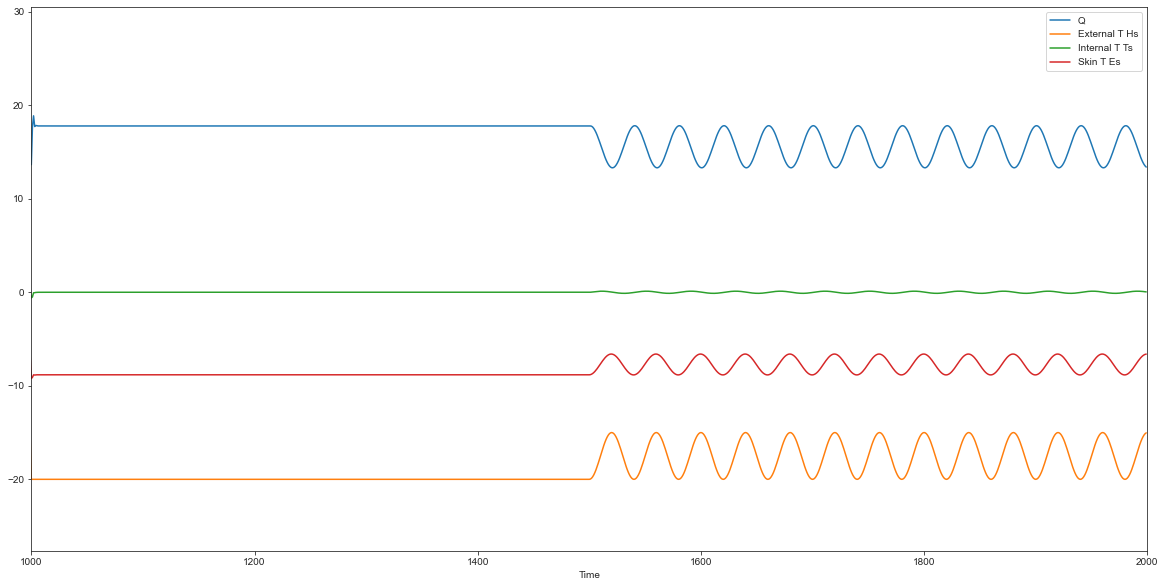

In [114]:
ts = list(range(len(wave_forms) * data_points))
plt.figure(figsize=(20,10))
plt.plot(ts, y_Qs, label= "Q")
plt.plot(ts, y_Hs, label= "External Temperature Hs")
plt.plot(ts, y_Ts, label= "Internal Temperature Ts")
plt.plot(ts, y_Es, label= "Skin Temperature Es")
plt.xlabel('Time')
plt.legend()
plt.xlim(0,1000)
plt.savefig('training_data.png')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(ts, y_Qs, label= "Q")
plt.plot(ts, y_Hs, label= "External T Hs")
plt.plot(ts, y_Ts, label= "Internal T Ts")
plt.plot(ts, y_Es, label= "Skin T Es")
plt.xlabel('Time')
plt.legend()
plt.xlim(1000,2000)
plt.savefig('test_data.png')

In [104]:
def convert_to_sequence(in_array, length):
    return np.array( [ np.array(in_array[i:j]) if j!=0 else np.array(in_array[i:]) for i,j in zip(range(length),range(-length+1,1)) ] ).T
def add_differential_terms(in_array, integral=True, differ=True):
    if integral and differ:
        int = np.array([np.sum(in_array[:,i:i+2],axis=1) for i in range(length-1)]).T
        der = np.array([in_array[:,i]-in_array[:,i+1] for i in range(length-1)]).T
        in_array = np.append(in_array, int, 1)
        return np.append(in_array, der, 1)
def and_skin():
    ipt = convert_to_sequence(y_Ts, length)
    ipt = add_differential_terms(ipt)
    seq = convert_to_sequence(y_Es, length)
    ipt = np.append(seq, ipt, 1)[:-1,:]
    return ipt
def gen_model(act_func = 'relu'):
    # inputs = keras.Input(shape=(2*length+(length-1)*2))
    inputs = keras.Input(shape=length)
    dense = layers.Dense(16, activation=act_func)(inputs)
    dense = layers.Dense(16, activation=act_func)(dense)
    outputs = keras.layers.Dense(1)(dense)
    model = keras.Model(inputs=inputs, outputs=outputs, name="NN_heat_controller")
    return model

In [85]:
length = 5

ipt = convert_to_sequence(y_Es, length)[:-1]
opt = np.array( [y_Qs[length:]] ).T

prop = 1/2
pointx, pointy = round(ipt.shape[0]*prop), round(opt.shape[0]*prop)
trainX, testX, trainy, testy = ipt[:pointx], ipt[pointx:], opt[:pointy], opt[pointy:]

print('input shape: {} , output shape: {}'.format(ipt.shape, opt.shape))

model = gen_model()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="mean_squared_error",
    metrics=["accuracy"])
history = model.fit(trainX, trainy, shuffle=True, epochs=500, verbose=0)
model.summary()



# plt.figure(figsize=(15,8))
# plt.plot( history.epoch, history.history['loss'], label='loss')
# plt.plot( history.epoch, history.history['accuracy'] , label= 'acc')
# plt.legend()

input shape: (1995, 5) , output shape: (1995, 1)
Model: "NN_heat_controller"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dense_69 (Dense)             (None, 16)                96        
_________________________________________________________________
dense_70 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_71 (Dense)             (None, 1)                 17        
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [126]:
def sequential_predict(model, x_start, conv=False, n_predict = 2000):
    fc_model = fc.X23_gToo_I(Bi, Fo, M=100)
    new_x = np.zeros(x_start.shape)
    
    Q = model.predict(x_start)[0][0]
    for i in range(start_point+length):
        fc_model.getNextTemp(y_Qs[i], y_Hs[i])
    v = fc_model.getNextTemp(Q, y_Hs[length+start_point])
    
    new_x[0,:length-1], new_x[0,length-1] = x_start[0,1:length], v[1]
    # new_x[0,length:2*length-1], new_x[0,2*length-1] = x_start[0,length:2*length-1], v[0]
    # new_x[0,2*length:3*length-1] = np.array([np.sum(new_x[0,i:i+2]) for i in range(length,2*length-1)])
    # new_x[0,3*length-1:] = np.array([ new_x[0,i]-new_x[0,i+1] for i in range(length,2*length-1)])
    results, T_core, T_skin = [Q], [v[0]], [v[1]]

    for j in range(1, n_predict):
        Q = model.predict(new_x)[0][0]
        v = fc_model.getNextTemp(Q, y_Hs[length+j+start_point])
        new_x[0,:length-1], new_x[0,length-1] = new_x[0,1:length], v[1]
        # new_x[0,length:2*length-1], new_x[0,2*length-1] = new_x[0,length:2*length-1], v[0]
        # new_x[0,2*length:3*length-1] = np.array([np.sum(new_x[0,i:i+2]) for i in range(length,2*length-1)])
        # new_x[0,3*length-1:] = np.array([ new_x[0,i+1]-new_x[0,i] for i in range(length,2*length-1)])
        T_core.append( v[0] ); results.append( Q ); T_skin.append(v[1])
    return results, T_core, T_skin
start_point = 0
size = 1800
Q_hat, core_hat, skin_hat = sequential_predict(model, ipt[start_point:(start_point+1)], n_predict=size)

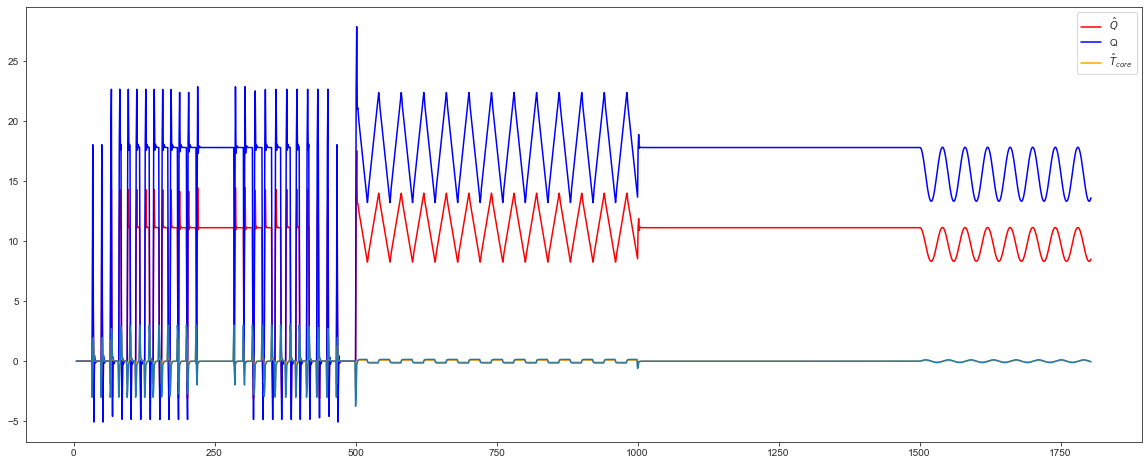

In [136]:
t = list(range(length+start_point,start_point+size+length))
plt.figure(figsize=(20,8))
plt.plot(t, Q_hat, label='$\hat{Q}$', color='red')
plt.plot(t, y_Qs[length+start_point:(length+start_point+size)], label='Q', color='blue')
plt.plot(t, core_hat, label='$\hat{T}_{core}$', color='orange')
plt.plot(t, y_Ts[length+start_point:(length+start_point+size)])
# plt.plot(t, y_Hs[length+start_point:(length+start_point+size)], label='$T_{\infty}$', color='purple')
# plt.plot(t, skin_hat, label='$T_{skin}$', color='green')
# plt.plot(t, y_Es[length+start_point:(length+start_point+size)], label='$T_s$', color='brown')
plt.legend()
plt.savefig("train_seq_predict.png")
# plt.xlim(1000,1500)
plt.show()

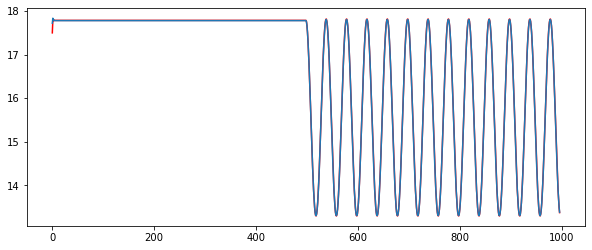

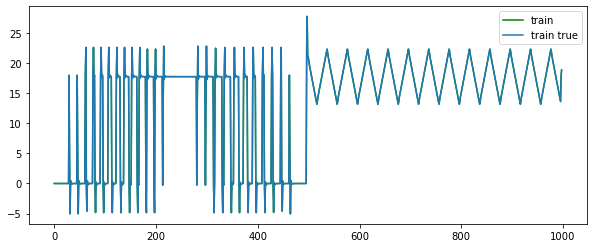

In [89]:
test_predict = model.predict(testX)
train_predict = model.predict(trainX)
t = list(range(len(test_predict-1)))
plt.figure(figsize=(10,4))
plt.plot(t, test_predict, label='Q_test', color='red')
plt.plot(t, testy[:,0], label='Q_test')
plt.show()

plt.figure(figsize=(10,4))
t = list(range(len(train_predict)))
plt.plot(t, train_predict, label='train', color='green')
plt.plot(t, trainy[:,0], label='train true')
plt.legend()
plt.show()

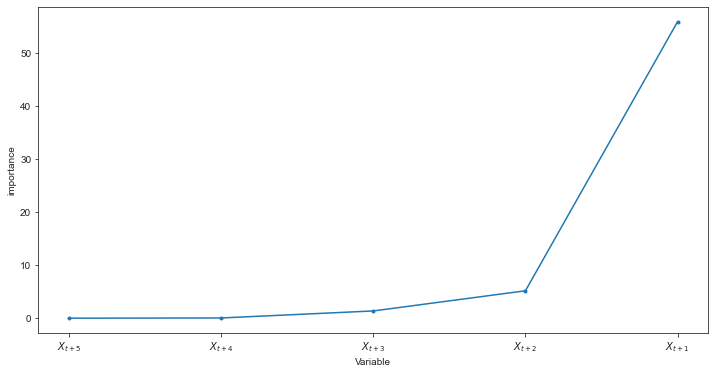

In [96]:
from sklearn.inspection import permutation_importance
import seaborn as sns
sns.set_style("ticks")
t = list(range(1,6))
result = permutation_importance(model, ipt, opt, scoring='neg_mean_squared_error', n_repeats=10)
plt.figure(figsize=(12,6))
plt.plot(t,result.importances_mean,'.-')
plt.xticks(t,['$X_{t+5}$','$X_{t+4}$','$X_{t+3}$', '$X_{t+2}$', '$X_{t+1}$'])
plt.xlabel('Variable')
plt.ylabel("importance")
plt.savefig("Perturbation.png")

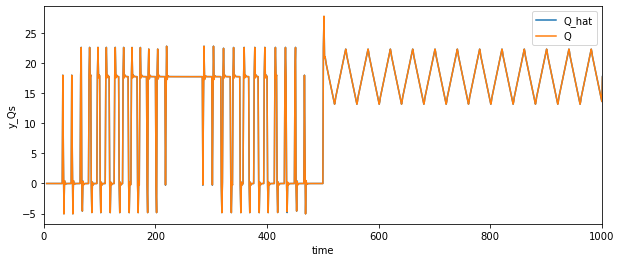

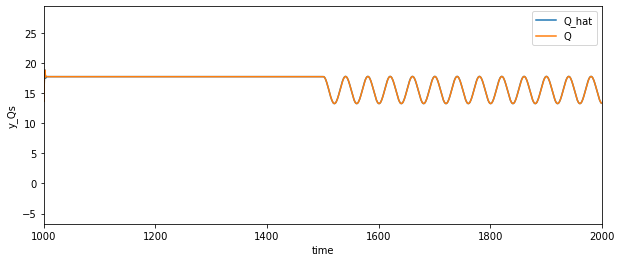

In [90]:
for i in range(1,3):
    plt.figure(figsize=(10,4))
    plt.ylabel("y_Qs")
    plt.xlabel("time")
    plt.plot(ts[(length):(data_points*len(wave_forms)+length)],model.predict(ipt), label="Q_hat")
    plt.plot(ts[(length):(data_points*len(wave_forms)+length)],y_Qs[(length):(ipt.shape[0]+length)],label='Q')
    plt.xlim((i-1)*1000,i*1000)
    plt.legend()
    plt.savefig('training.png')
    plt.show()